In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Importing all the relevant libraries

In [ ]:
import pandas as pd
import seaborn as sns
import math
import sys
from numpy import mean
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.svm import OneClassSVM
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

##Exploring the dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TheRealReal/Therealreal.txt', sep=",")

In [ ]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


deleting the date column because it doesnt contribute anything since theres no recurring corellation pattern between date and failure

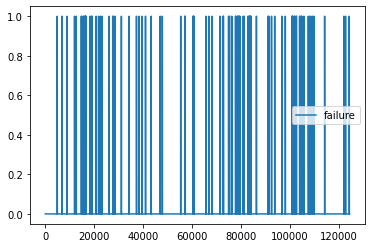

In [ ]:
df[['date','failure']].plot()
del df['date']

In [ ]:
df['failure'].value_counts()

0    124388
1       106
Name: failure, dtype: int64

We can't fit our model on the "device" column because it has categorical string values, so we perform Label Encoding on it

In [ ]:
df['device'].value_counts()

85      304
666     304
972     304
974     304
975     304
       ... 
1032      5
1033      5
893       5
31        4
730       3
Name: device, Length: 1168, dtype: int64

In [ ]:
#Label Encoding of the device column
gle = LabelEncoder()
labels = gle.fit_transform(df['device'])
genre_mappings = {index: label for index, label in enumerate(gle.classes_)}
df['device'] = labels

## Metric Used for Evaluation
The metric I've used for evaluation here is the F1 score because we have imbalanced classes and using accuracy in such casses would be redundant since the accuracy would be really high even if it made the same prediction for the entire dataset.

I've also used Accuracy as an evaluation metric after upsampling the dataset.

## Applying Basic Logistic Regression without Upsampling

In [ ]:
#Splitting data into training 70% and test set 30%

df_train, df_test = train_test_split(df, test_size=0.3, random_state=25)

print(f"No. of training examples: {df_train.shape[0]}")
print(f"No. of testing examples: {df_test.shape[0]}")

No. of training examples: 87145
No. of testing examples: 37349


In [ ]:
X_train, y_train = df_train.drop('failure', axis=1), df_train.failure
clf_0 = LogisticRegression().fit(X_train, y_train)

#checking the performance of the model
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(clf_0, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
print('Mean F1 Score: %.3f' % mean(scores))

#Testing the Model
X_test, y_test = df_test.drop('failure', axis=1),df_test.failure
y_pred = clf_0.predict(X_test)

#F1 score for X_test
print("F1 score on test set:",f1_score(np.array(y_test), y_pred))

Mean F1 Score: 0.016
F1 score on test set: 0.0


##Upsampling Data

In [ ]:
#upsampling the data so both classes have equal number of examples
df_majority = df[df.failure==0]
df_minority = df[df.failure==1]
df_minority_upsampled = resample(df_minority,replace=True,n_samples=124388,random_state=123)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled.failure.value_counts()

0    124388
1    124388
Name: failure, dtype: int64

In [ ]:
df_upsampled

,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,0,0,215630672,56,0,52,6,407438,0,0,7
1,2,0,61370680,0,3,0,6,403174,0,0,0
2,3,0,173295968,0,0,0,12,237394,0,0,0
3,4,0,79694024,0,0,0,6,410186,0,0,0
4,5,0,135970480,0,0,0,15,313173,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...
27572,684,1,40958456,1320,0,2,37,277142,0,0,5
122118,113,1,13739704,0,0,18,8,343760,0,0,0
65670,886,1,180215128,2256,0,12,8,190301,32,32,0
27803,1046,1,167367224,0,0,0,12,326075,0,0,0


# Logistic Regression on Upsampled Data

In [ ]:
#Splitting data into training 70% and test set 30%

df_upsampled_train, df_upsampled_test = train_test_split(df_upsampled, test_size=0.3, random_state=25)

print(f"No. of training examples: {df_upsampled_train.shape[0]}")
print(f"No. of testing examples: {df_upsampled_test.shape[0]}")

No. of training examples: 174143
No. of testing examples: 74633


In [ ]:
#basic logistic with -> Labels Encoded and upsampling
X_train, y_train = df_upsampled_train.drop('failure', axis=1), df_upsampled_train.failure
clf_1 = LogisticRegression().fit(X_train, y_train)

#checking the performance of the model
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(clf_1, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
print('Mean F1 Score: %.3f' % mean(scores))

#Testing the Model
X_test, y_test = df_upsampled_test.drop('failure', axis=1),df_upsampled_test.failure
y_pred = clf_1.predict(X_test)

#F1 score for X_test
print("F1 score on test set:",f1_score(np.array(y_test), y_pred))
print("Accuracy on test set:", accuracy_score(np.array(y_test), y_pred)*100)

Mean F1 Score: 0.547
F1 score on test set: 0.5440759992830255
Accuracy on test set: 65.91856149424518


# Logistic Regression on Scaled and Upsampled Data

In [ ]:
#Scaling the features except failure column
df_scaled = df_upsampled.copy()
col_names = ['attribute1','attribute2','attribute3','attribute4',	'attribute5',	'attribute6',	'attribute7',	'attribute8',	'attribute9']
features = df_scaled[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
df_scaled[col_names] = features

In [ ]:
df_scaled_train, df_scaled_test = train_test_split(df_scaled, test_size=0.3, random_state=25)

print(f"No. of training examples: {df_upsampled_train.shape[0]}")
print(f"No. of testing examples: {df_upsampled_test.shape[0]}")

No. of training examples: 174143
No. of testing examples: 74633


In [ ]:
#scaled all columns except failure and device + Simple Logistic Regression
X_train, y_train = df_scaled_train.drop('failure', axis=1), df_scaled_train.failure
clf_2 = LogisticRegression().fit(X_train, y_train)

#checking the performance of the model
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(clf_2, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
print('Mean F1 Score: %.3f' % mean(scores))

#Testing the Model
X_test, y_test = df_scaled_test.drop('failure', axis=1),df_scaled_test.failure
y_pred = clf_2.predict(X_test)

#F1 score for X_test
print("F1 score on test set:",f1_score(np.array(y_test), y_pred))
print("Accuracy on test set:", accuracy_score(np.array(y_test), y_pred)*100)

Mean F1 Score: 0.725
F1 score on test set: 0.7296538517713117
Accuracy on test set: 77.67877480471105


# Random Forest Classifier on Scaled and Upsampled Data

In [ ]:
#scaled all columns except failure and device + Random Forest Classifier
X_train, y_train = df_scaled_train.drop('failure', axis=1), df_scaled_train.failure
clf_3= RandomForestClassifier(max_depth=2, random_state=0)
clf_3.fit(X_train, y_train)

#checking the performance of the model
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(clf_3, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
print('Mean F1 Score: %.3f' % mean(scores))

#Testing the Model
X_test, y_test = df_scaled_test.drop('failure', axis=1),df_scaled_test.failure
y_pred = clf_3.predict(X_test)

#F1 score for X_test
print("F1 score on test set:",f1_score(np.array(y_test), y_pred))
print("Accuracy on test set:", accuracy_score(np.array(y_test), y_pred)*100)

Mean F1 Score: 0.832
F1 score on test set: 0.8310650096409621
Accuracy on test set: 83.91730199777578


# Logistic Regression + Random Forest Classifier on Scaled and Upsampled A.K.A Best Model

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#scaled all columns except failure and device + Random Forest Classifier
X_train, y_train = df_scaled_train.drop('failure', axis=1), df_scaled_train.failure
clf1 = LogisticRegression(random_state=42)
clf2 = RandomForestClassifier(random_state=42)

eclf = VotingClassifier(estimators=[('LR', clf1), ('RF', clf2)],voting='soft', weights=[1,2])
eclf.fit(X_train, y_train)

#checking the performance of the model
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
scores = cross_val_score(eclf, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
print('Mean F1 Score: %.3f' % mean(scores))

#Testing the Model
X_test, y_test = df_scaled_test.drop('failure', axis=1),df_scaled_test.failure
y_pred = eclf.predict(X_test)

#F1 score for X_test
print("F1 score on test set:",f1_score(np.array(y_test), y_pred))
print("Accuracy on test set:", accuracy_score(np.array(y_test), y_pred)*100)

Mean F1 Score: 0.999
F1 score on test set: 0.9997053860781531
Accuracy on test set: 99.97052242305683


# THEREALREAL.PY

In [ ]:
class TheRealReal_Model():
  def __init__(self, train_path, test_path):
    self.df_train = pd.read_csv(train_path, sep=",")
    self.df_test = pd.read_csv(test_path, sep=",")

  def preprocess_train(self):
    #deleting date column
    del self.df_train['date']

    #Label Encoding
    gle = LabelEncoder()
    labels = gle.fit_transform(self.df_train['device'])
    genre_mappings = {index: label for index, label in enumerate(gle.classes_)}
    self.df_train['device'] = labels

    #Upsampling if class imbalance exists
    if self.df_train['failure'].value_counts()[0] > 2 * self.df_train['failure'].value_counts()[1]:
      majority = 0
      minority = 1
    elif self.df_train['failure'].value_counts()[1] > 2 * self.df_train['failure'].value_counts()[0]:
      majority = 1
      minority = 0
    df_majority = self.df_train[self.df_train.failure == majority]
    df_minority = self.df_train[self.df_train.failure == minority]
    df_minority_upsampled = resample(df_minority,replace=True,n_samples=self.df_train['failure'].value_counts()[majority],random_state=123)
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    #Scaling Data
    df_scaled_train = df_upsampled.copy()
    col_names = ['attribute1','attribute2','attribute3','attribute4',	'attribute5',	'attribute6',	'attribute7',	'attribute8',	'attribute9']
    features = df_scaled_train[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df_scaled_train[col_names] = features

    return df_scaled_train

  def preprocess_test(self):
    #deleting date column
    del self.df_test['date']

    #Label Encoding
    gle = LabelEncoder()
    labels = gle.fit_transform(self.df_test['device'])
    genre_mappings = {index: label for index, label in enumerate(gle.classes_)}
    self.df_test['device'] = labels

    #Scaling Data
    df_scaled_test = self.df_test.copy()
    col_names = ['attribute1','attribute2','attribute3','attribute4',	'attribute5',	'attribute6',	'attribute7',	'attribute8',	'attribute9']
    features = df_scaled_test[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df_scaled_test[col_names] = features

    return df_scaled_test

  def train_function(self):

    df_scaled = self.preprocess_train()

    X_train, y_train = df_scaled.drop('failure', axis=1), df_scaled.failure

    clf1 = LogisticRegression(random_state=42)
    clf2 = RandomForestClassifier(random_state=42)

    self.eclf = VotingClassifier(estimators=[('LR', clf1), ('RF', clf2)],voting='soft', weights=[1,2])
    self.eclf.fit(X_train, y_train)

    #checking the performance of the model
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
    scores = cross_val_score(self.eclf, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
    print('Mean F1 Score: %.3f' % mean(scores))

  def test_function(self):

    df_scaled_test = self.preprocess_test()

    #Testing the Model
    X_test = df_scaled_test
    y_pred = self.eclf.predict(X_test)

    self.df_test['predictions'] = y_pred
    self.df_test.to_csv('predictions.csv')

  def fit_and_predict_data(self):
    self.train_function()
    self.test_function()
